In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import sklearn as sk

print("tf.__version__ = ", tf.__version__)
print("pd.__version__ = ", pd.__version__)
print("sklearn.__version__ = ", sk.__version__)

tf.__version__ =  2.20.0
pd.__version__ =  2.3.3
sklearn.__version__ =  1.7.2


In [10]:
lc = pd.read_csv("C:/Users/Momen/PycharmProjects/JupyterProject/CS415_Project/Dataset/lung_cancer_dataset.csv")
lc['alcohol_consumption'] = lc['alcohol_consumption'].replace('None', 'None_val')
lc.head()
lc.info()
# lc_shape = lc.shape  # (rows, columns)
# print(lc_shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   patient_id                 50000 non-null  int64  
 1   age                        50000 non-null  int64  
 2   pack_years                 50000 non-null  float64
 3   gender                     50000 non-null  object 
 4   radon_exposure             50000 non-null  object 
 5   asbestos_exposure          50000 non-null  object 
 6   secondhand_smoke_exposure  50000 non-null  object 
 7   copd_diagnosis             50000 non-null  object 
 8   alcohol_consumption        33338 non-null  object 
 9   family_history             50000 non-null  object 
 10  lung_cancer                50000 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 4.2+ MB


In [11]:
#     CHECK 1: MISSING VALUES
# ==========================================
print("\n Checking for Missing Data...")
missing_values = lc.isna().sum()

# Filter to show only columns that actually have missing values
missing_only = missing_values[missing_values > 0]

if missing_only.empty:
    print("Great! No missing values found in any column.")
else:
    print("Found missing values in these columns:")
    print(missing_only)


 Checking for Missing Data...
Found missing values in these columns:
alcohol_consumption    16662
dtype: int64


In [12]:
# CHECK 2: DUPLICATES
# ==========================================
print("\n Checking for Duplicates...")

# Copying the data
df = lc.copy()


# We exclude 'index' and 'Patient Id' because unique IDs hide real duplicates
# cols_to_check = df.columns.drop(['index', 'Patient Id'])

# 'keep=False' marks ALL duplicates as True so we can see them
duplicate_rows = df[df.duplicated(subset=df.columns, keep=False)]
num_duplicates = df.duplicated(subset=df.columns).sum()

print(f"Total duplicate rows found: {num_duplicates}")

if num_duplicates > 0:
    print("\n Here is a preview of the duplicates (Top 6 rows):")
    # We sort them so you can see the identical pairs side-by-side
    print(duplicate_rows.sort_values(by=['AGE', 'GENDER']).head(6))

    # ==========================================
    #     ACTION: REMOVE DUPLICATES
    # ==========================================
#     print(f"\ Removing duplicates...")
#     # Keep the first occurrence, drop the rest
#     df = df.drop_duplicates(subset=cols_to_check, keep='first')
#     print(f" Duplicates removed. New dataset shape: {df.shape}")
#
# else:
#     print(" No duplicates found. The data is unique.")


 Checking for Duplicates...
Total duplicate rows found: 0


In [13]:
# Drop 'id' (it's not a feature)
df = df.drop(columns=['patient_id'])
if not ('patient_id' in df.columns):
    print("Dropped 'patient_id'")

Dropped 'patient_id'


In [14]:
# Create a new column: Cumulative Damage
df['cumulative_smoking'] = df['age'] * df['pack_years']

In [15]:
# Encode the string columns
from sklearn.preprocessing import LabelEncoder

# 1. Fix the "None" issue first
# df['alcohol_consumption'] = df['alcohol_consumption'].replace('None', 'None_val')
# Rename to avoid NaN if needed, or fillna
df = df.fillna('None') # Just in case

# 2. Manual Map for Ordinals (Crucial for hierarchy)
ord_mapping = {
    'Low': 0, 'Medium': 1, 'High': 2,       # Radon
    'None': 0, 'Moderate': 1, 'Heavy': 2,   # Alcohol
}

# Apply map ONLY to specific ordinal columns
target_cols = ['radon_exposure', 'alcohol_consumption']
for col in target_cols:
    df[col] = df[col].map(ord_mapping)

# 3. Automate the rest (Gender, Yes/No, etc.)
# We loop through every column that is still Text (Object)
le = LabelEncoder()

for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])
    print(f"Encoded {col}: {le.classes_}")

print("\nAll Done! Data is numeric.")
print(df.info())

Encoded gender: ['Female' 'Male']
Encoded asbestos_exposure: ['No' 'Yes']
Encoded secondhand_smoke_exposure: ['No' 'Yes']
Encoded copd_diagnosis: ['No' 'Yes']
Encoded family_history: ['No' 'Yes']
Encoded lung_cancer: ['No' 'Yes']

All Done! Data is numeric.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        50000 non-null  int64  
 1   pack_years                 50000 non-null  float64
 2   gender                     50000 non-null  int64  
 3   radon_exposure             50000 non-null  int64  
 4   asbestos_exposure          50000 non-null  int64  
 5   secondhand_smoke_exposure  50000 non-null  int64  
 6   copd_diagnosis             50000 non-null  int64  
 7   alcohol_consumption        50000 non-null  int64  
 8   family_history             50000 non-null  int64  
 9   lung_cancer 

In [16]:
#     STEP 3: SPLIT & SCALE
# ==========================================
from sklearn.preprocessing import StandardScaler

X = df.drop('lung_cancer', axis=1)
y = df['lung_cancer']

# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale Features (Crucial for Medical Data)
# We must scale them to be equal.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Ready for Neural Network!")
print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape: {X_test.shape}")

Ready for Neural Network!
Training Shape: (40000, 10)
Testing Shape: (10000, 10)


In [32]:

model = keras.Sequential([
    # Input
    keras.Input(shape=(X_train.shape[1],)),

    # Layer 1: Big Brain
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),  # # Reduced from 0.3 -> 0.1 (Less braking)

    # Layer 2: Medium Brain
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),  # Reduced from 0.2 -> 0.1

    # Layer 3: Summary
    layers.Dense(32, activation='relu'),
    # No dropout needed here usually, as it's small

    # Output
    layers.Dense(1, activation='sigmoid')
])

In [33]:
# STEP 4: Compile & ADD CLASS WEIGHTS
from tensorflow.keras.metrics import AUC, Precision, Recall
from sklearn.utils import class_weight
import numpy as np

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

# Calculate weights automatically
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
weight_dict = dict(enumerate(weights))

In [34]:
# STEP 5: Train

from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    # CHANGE 1: Increase Batch Size for 50k rows
    batch_size=64,

    # CHANGE 2: Since we have 50k rows, using a real validation split
    # is better than reusing the Test set.
    validation_split=0.2,

    callbacks=[early_stop],

    class_weight=weight_dict, # <--- Added this!

    verbose=2
)

# ==========================================
#    PLOT THE LEARNING CURVE
# ==========================================
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss') # Fixed label
plt.title('Loss Curve')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') # Fixed label
plt.title('Accuracy Curve')
plt.legend()

plt.show()

Epoch 1/100


KeyboardInterrupt: 

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 1. Evaluate
# 1. Evaluate (Returns a list of all metrics)
results = model.evaluate(X_test, y_test)

# 2. Print them nicely using the internal names
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")



313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6936 - auc: 0.7674 - loss: 0.5593 - precision: 0.8285 - recall: 0.6988
loss: 0.5593
compile_metrics: 0.6936


In [25]:
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score

# Get the raw probabilities once
y_pred_prob = model.predict(X_test)

# List of thresholds to test
thresholds_to_test = [0.3, 0.4, 0.5, 0.6, 0.7]

print(f"{'Threshold':<10} | {'Recall':<10} | {'Precision':<10} | {'F1-Score':<10}")
print("-" * 50)

for t in thresholds_to_test:
    # Convert probabilities to 0 or 1 based on 't'
    custom_preds = (y_pred_prob > t).astype(int)

    # Calculate scores
    rec = recall_score(y_test, custom_preds)
    prec = precision_score(y_test, custom_preds)
    f1 = f1_score(y_test, custom_preds)

    # Print the row
    print(f"{t:<10} | {rec:.4f}     | {prec:.4f}        | {f1:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Threshold  | Recall     | Precision  | F1-Score  
--------------------------------------------------
0.3        | 0.9326     | 0.7482        | 0.8303
0.4        | 0.8384     | 0.7880        | 0.8124
0.5        | 0.6988     | 0.8285        | 0.7582
0.6        | 0.5318     | 0.8725        | 0.6608
0.7        | 0.3626     | 0.9216        | 0.5204



📊 Model Performance:
   -> loss: 0.5593
   -> compile_metrics: 0.6936
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

First 10 Predictions (Threshold 0.3):
Pred: 0 | Actual: 0 | Prob: 0.0476
Pred: 1 | Actual: 0 | Prob: 0.3068
Pred: 1 | Actual: 1 | Prob: 0.5425
Pred: 1 | Actual: 1 | Prob: 0.3953
Pred: 0 | Actual: 0 | Prob: 0.1792
Pred: 1 | Actual: 1 | Prob: 0.7408
Pred: 1 | Actual: 1 | Prob: 0.7569
Pred: 1 | Actual: 1 | Prob: 0.5678
Pred: 1 | Actual: 0 | Prob: 0.6426
Pred: 1 | Actual: 0 | Prob: 0.3316

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.31      0.43      3127
           1       0.75      0.93      0.83      6873

    accuracy                           0.74     10000
   macro avg       0.71      0.62      0.63     10000
weighted avg       0.73      0.74      0.70     10000



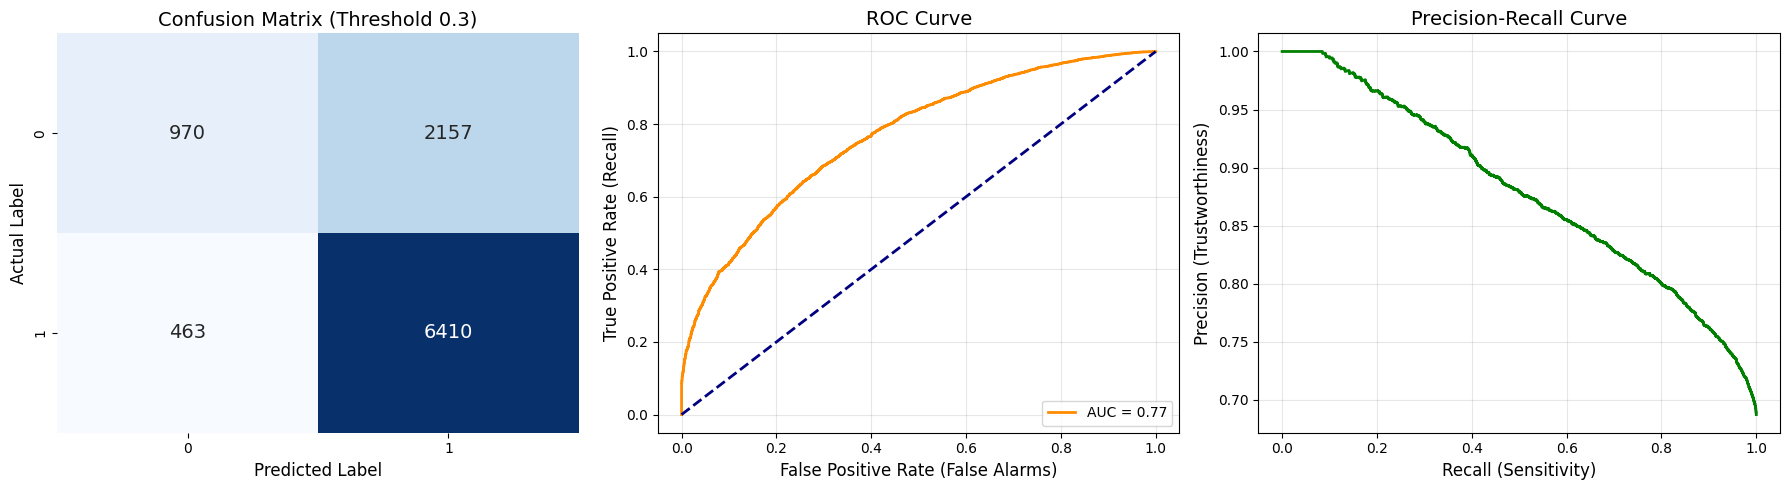

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

# ==========================================
# 1. EVALUATE & PREDICT
# ==========================================
# ==========================================
# 1. EVALUATE (Crash-Proof Version)
# ==========================================
results = model.evaluate(X_test, y_test, verbose=0)

print("\n📊 Model Performance:")
# If results is just a single number (Loss only), make it a list
if not isinstance(results, list):
    results = [results]

# Print whatever metrics are available
for name, value in zip(model.metrics_names, results):
    print(f"   -> {name}: {value:.4f}")

# Get raw probabilities
predictions = model.predict(X_test)

# APPLY YOUR CHOSEN THRESHOLD (0.3)
THRESHOLD = 0.3
predicted_classes = (predictions > THRESHOLD).astype("int32")
actual_classes = np.array(y_test)

# ==========================================
# 2. TEXT REPORT
# ==========================================
print("\nFirst 10 Predictions (Threshold 0.3):")
for i in range(10):
    print(f"Pred: {predicted_classes[i][0]} | Actual: {actual_classes[i]} | Prob: {predictions[i][0]:.4f}")

print("\nClassification Report:")
print(classification_report(actual_classes, predicted_classes))

# ==========================================
# 3. PLOTS
# ==========================================
plt.figure(figsize=(18, 5))

# --- Plot A: Confusion Matrix ---
plt.subplot(1, 3, 1)
cm = confusion_matrix(actual_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size': 14})
plt.title(f'Confusion Matrix (Threshold {THRESHOLD})', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('Actual Label', fontsize=12)

# --- Plot B: ROC Curve (Good for overall performance) ---
fpr, tpr, _ = roc_curve(actual_classes, predictions)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random guess line
plt.xlabel('False Positive Rate (False Alarms)', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curve', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# --- Plot C: Precision-Recall Curve (Best for Imbalanced Data) ---
precision, recall, _ = precision_recall_curve(actual_classes, predictions)

plt.subplot(1, 3, 3)
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall (Sensitivity)', fontsize=12)
plt.ylabel('Precision (Trustworthiness)', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
# Save the entire model (architecture + weights + optimizer state)
model.save("Lung_Cancer.keras")
print("Model saved to disk!")

Model saved to disk!


In [35]:
import joblib
# This file remembers the "Mean" and "Std Dev" of your training data
joblib.dump(scaler, 'breast_cancer_scaler.pkl')

['breast_cancer_scaler.pkl']